# Multi-Signal Strategy Simulation on S&P 500 — Part 4 (Results)

**Universe:** 478 tickers (≈2.31M daily rows per strategy) loaded from local Parquet.
**Outputs used:** CSVs in `output/` produced by `Simulation.py`.

**Execution rules**
- **T+1 execution** (signals shift; trades placed on the next bar).
- **No shorts**
- Strategy “signal” equals **shares to buy** for that day.
- Portfolio series are formed by **summing per-ticker cash/holdings**; a baseline **+\$1,000,000** is added at the end (as in `Simulation.py`).


In [1]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (11, 5)
CSV_DIR = "output"                # where Simulation.py wrote files
SIG_DIR = Path(CSV_DIR) / "signals"

def load_portfolio_csv(path):
    df = pd.read_csv(path, parse_dates=["Date"]).sort_values("Date").reset_index(drop=True)
    if "PnL" not in df.columns:
        df["PnL"] = df["Total Assets"] - df["Total Assets"].iloc[0]
    return df

def sharpe_maxdd(df):
    tv = df["Total Assets"]
    r  = tv.pct_change().dropna()
    sharpe = (r.mean()/r.std()*np.sqrt(252)) if len(r)>1 and r.std()>0 else np.nan
    maxdd  = ((tv / tv.cummax()) - 1).min() * 100.0
    return float(sharpe), float(maxdd)


## Signal Overlay (per-ticker)

**What to look for:** buy markers align with the strategy’s logic and are **executed T+1** (markers appear on the trade day, not the signal day).

- **MA(20/50):** clustered buys when 20D crosses/holds above 50D (trend-following).
- **Volatility Breakout:** sparse, bursty buys on large positive moves (daily return > 20D stdev).
- **MACD:** buys only on line–signal crossovers; fewer entries than SMA regime.
- **RSI(14):** buys oversold dips (RSI < 30); more frequent in sell-offs/chop, rare in strong uptrends.
- **Benchmark:** single day-1 block per name; no further trades.


In [16]:
# portfolio series (exclude timing files)
portfolio_files = [p for p in glob.glob(f"{CSV_DIR}/*.csv")
                   if not p.endswith("_timing.csv") and "timing_summary" not in p]
assert portfolio_files, f"No portfolio CSVs found in '{CSV_DIR}'. Run Simulation.py first."

ports = {Path(p).stem: load_portfolio_csv(p) for p in portfolio_files}

# timing summary
ts_path = Path(CSV_DIR) / "timing_summary.csv"
assert ts_path.exists(), "timing_summary.csv missing — re-run Simulation.py"
timing_df = pd.read_csv(ts_path).set_index("strategy")
ports.keys(), timing_df


(dict_keys(['BenchmarkStrategy', 'MACDStrategy', 'MovingAverageStrategy', 'RSIStrategy', 'VolatilityBreakoutStrategy']),
                             tickers  rows_total  trades_total    load_s  \
 strategy                                                                  
 MACDStrategy                    478     2307229         93367  0.616188   
 BenchmarkStrategy               478     2307707          4780  0.697334   
 MovingAverageStrategy           478     2307229       1392269  0.593745   
 VolatilityBreakoutStrategy      478     2298147        358466  0.596586   
 RSIStrategy                     478     2301476         69227  0.631211   
 
                             signal_s      sim_s    total_s  
 strategy                                                    
 MACDStrategy                1.137648  73.234758  74.988594  
 BenchmarkStrategy           0.140268  73.701429  74.539031  
 MovingAverageStrategy       0.547699  73.049438  74.190882  
 VolatilityBreakoutStrategy  0.6064

## Portfolio Lines — Holdings, Cash, Total Assets (by strategy)

**Chart characteristics:**
- **Holdings** (blue) rises with both price and share count.
- **Cash** (orange) steps down when buys occur. Because this run sums per-ticker without a shared cash gate, some strategies show **large negative cash** over time.
- **Total Assets** (green) = Cash + Holdings.

**Observed patterns**
- **MovingAverageStrategy** deploys capital continuously through long uptrends → very large holdings value; cash trends negative due to frequent buys in the aggregated (non-constrained) setup.
- **VolatilityBreakoutStrategy** shows stair-step holdings growth after momentum bursts.
- **MACDStrategy / RSIStrategy** deploy more selectively; cash declines more gradually; total assets grow but trail MA and VolBreak.
- **BenchmarkStrategy** shows a near-flat cash line after day 1 and steadily compounding holdings.


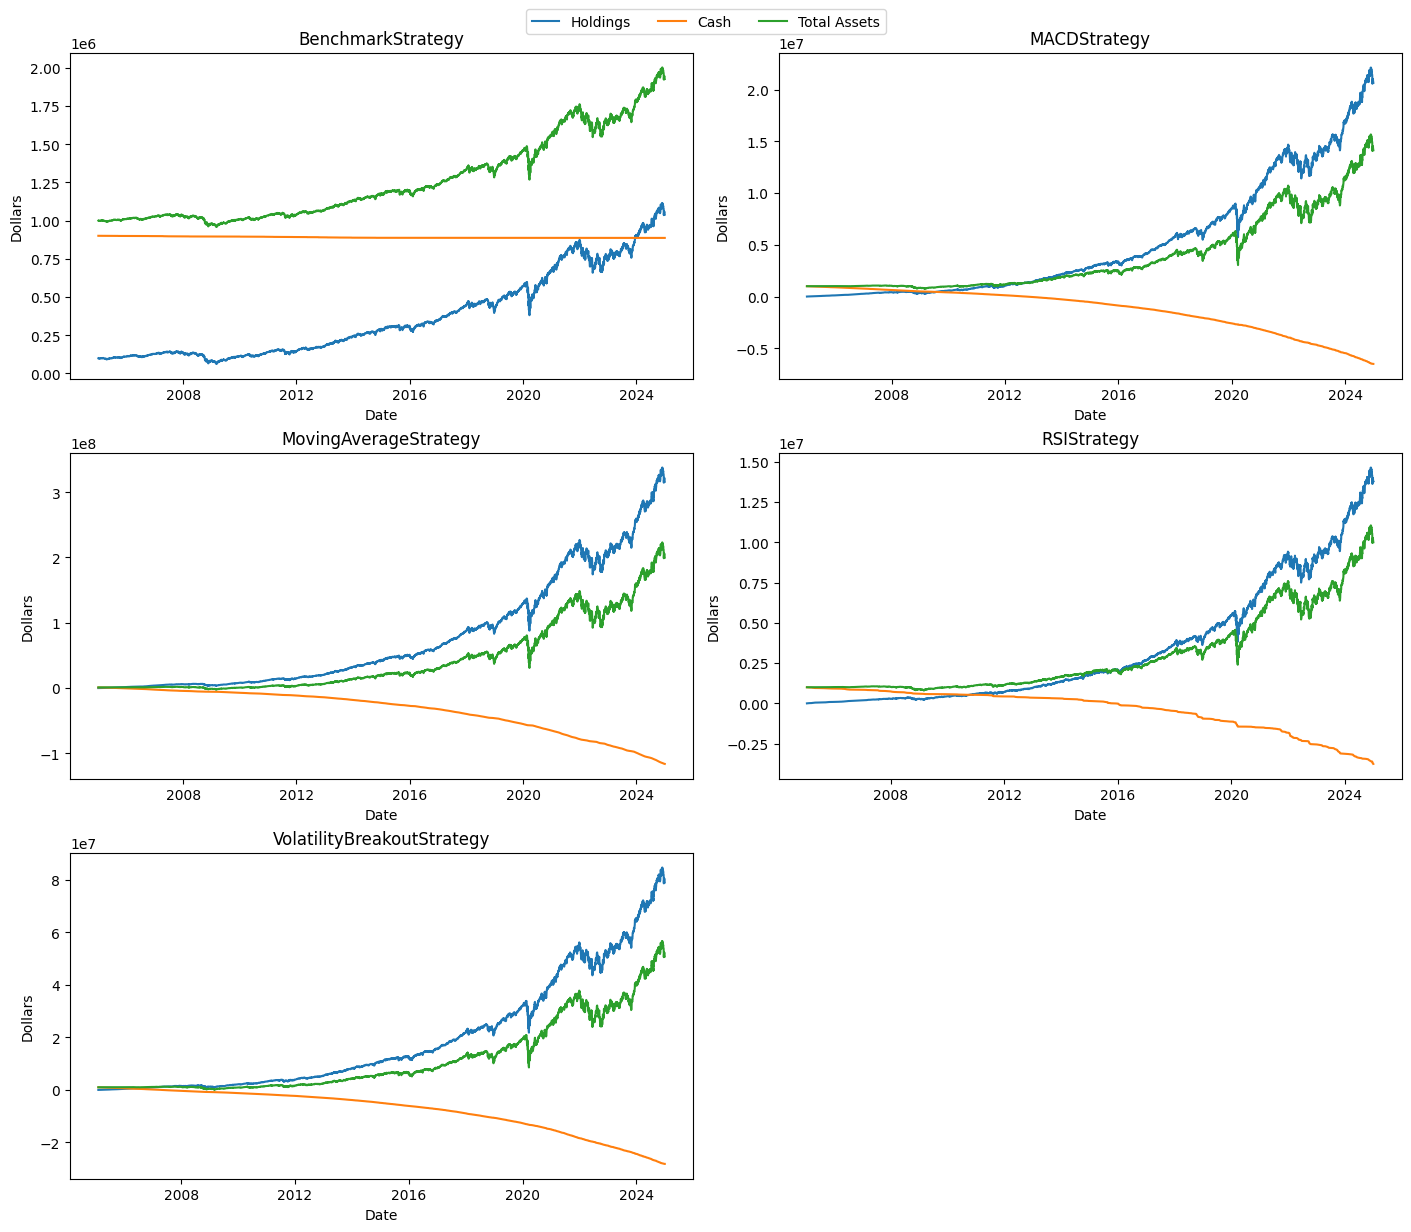

In [15]:

names = sorted(ports.keys())
ncols = 2
nrows = (len(names) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows, ncols, figsize=(14, 4*nrows), constrained_layout=True)
axes = np.array(axes).ravel()  # flattening

for i, name in enumerate(names):
    d = ports[name]
    ax = axes[i]
    ax.plot(d["Date"], d["Holdings"],     label="Holdings")
    ax.plot(d["Date"], d["Cash"],         label="Cash")
    ax.plot(d["Date"], d["Total Assets"], label="Total Assets")
    ax.set_title(name)
    ax.set_xlabel("Date"); ax.set_ylabel("Dollars")

for j in range(i+1, len(axes)):
    axes[j].axis("off")

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=3, bbox_to_anchor=(0.5, 1.02))

plt.show()


## Cumulative PnL — Portfolio (All Strategies)

**Top-line results (from the table):**
- **MovingAverageStrategy** — Total Return ≈ **\$198.9M**; **Sharpe ≈ −0.04**; **Max DD ≈ −210.7%**
  (Very high absolute PnL from heavy exposure; the negative Sharpe/DD reflect the unconstrained cash series in this aggregate run.)
- **VolatilityBreakoutStrategy** — Total Return ≈ **\$49.8M**; **Sharpe ≈ 0.65**; **Max DD ≈ −90.8%**
- **MACDStrategy** — Total Return ≈ **\$13.1M**; **Sharpe ≈ 0.73**; **Max DD ≈ −51.7%**
- **RSIStrategy** — Total Return ≈ **\$9.0M**; **Sharpe ≈ 0.72**; **Max DD ≈ −47.3%**
- **BenchmarkStrategy** — Total Return ≈ **\$0.93M**; **Sharpe ≈ 0.66**; **Max DD ≈ −14.6%**

**Interpretation**
- **MA(20/50)** dominates **absolute** PnL because it remains invested across broad uptrends and buys frequently.
  However, because cash is not shared-constrained, **risk stats** (Sharpe/DD) are distorted downward.
- **Volatility Breakout** harvests momentum bursts across the universe; strong absolute PnL with healthy Sharpe.
- **MACD / RSI** are more selective (fewer trades) → smaller PnL but competitive/strong Sharpe in this run.
- **Benchmark** lags on PnL (one-shot buy) but is stable and interpretable.


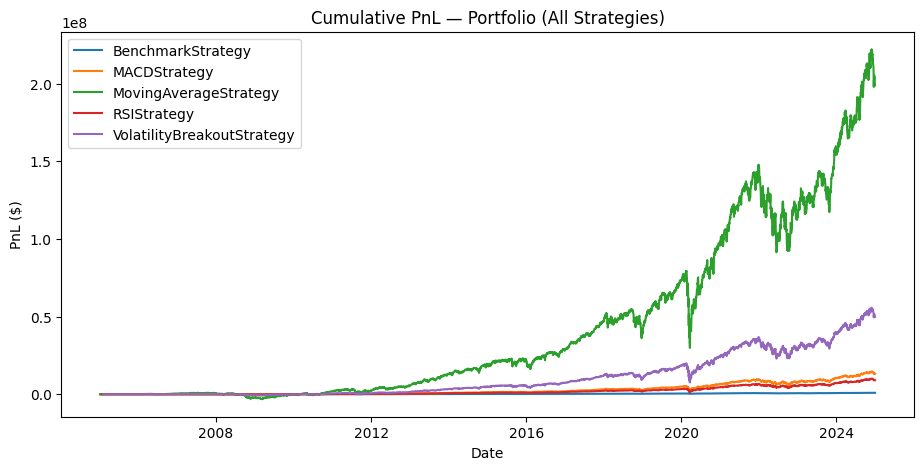

,Total Return ($),Max Drawdown (%),"Sharpe (≈, daily)"
Strategy,,,
MovingAverageStrategy,1.988605e+08,-210.722109,-0.035939
VolatilityBreakoutStrategy,4.979841e+07,-90.840675,0.644591
MACDStrategy,1.314709e+07,-51.706724,0.733672
RSIStrategy,9.006316e+06,-47.284025,0.721729
BenchmarkStrategy,9.262872e+05,-14.625422,0.656929


In [8]:
fig, ax = plt.subplots()
for name, d in sorted(ports.items()):
    ax.plot(d["Date"], d["PnL"], label=name)
ax.set_title("Cumulative PnL — Portfolio (All Strategies)")
ax.set_xlabel("Date"); ax.set_ylabel("PnL ($)"); ax.legend()
plt.show()

#stats table
stats = []
for name, d in ports.items():
    sharpe, dd = sharpe_maxdd(d)
    stats.append({"Strategy": name,
                  "Total Return ($)": float(d["PnL"].iloc[-1]),
                  "Max Drawdown (%)": dd,
                  "Sharpe (≈, daily)": sharpe})
stats_df = (pd.DataFrame(stats)
            .set_index("Strategy")
            .sort_values("Total Return ($)", ascending=False))
stats_df


In [11]:
# --- Build daily volume (shares + dollars) per strategy from signals CSVs ---
from pathlib import Path

strategy_names = sorted(ports.keys())  # e.g. ['BenchmarkStrategy', 'MACDStrategy', ...]
vol_shares = {}    # {strategy -> pd.Series indexed by Date}
vol_dollars = {}   # {strategy -> pd.Series indexed by Date}

for name in strategy_names:
    files = sorted((SIG_DIR).glob(f"{name}_*.csv"))
    assert files, f"No signal CSVs found for {name} in {SIG_DIR}"

    parts = []
    for fp in files:
        s = pd.read_csv(fp, parse_dates=["Date"])
        # normalize price column
        if "Close" not in s.columns and "AdjClose" in s.columns:
            s = s.rename(columns={"AdjClose": "Close"})
        # keep only needed columns
        s = s[["Date", "signal", "Close"]].copy()
        # dollar volume = shares * price
        s["dollar"] = s["signal"] * s["Close"]
        parts.append(s)

    S = pd.concat(parts, ignore_index=True)
    daily = S.groupby("Date", as_index=False)[["signal", "dollar"]].sum()

    # align dates to the portfolio series of that strategy (optional, for consistent x-axis)
    idx = ports[name]["Date"]
    shares_series  = daily.set_index("Date")["signal"].reindex(idx).fillna(0.0)
    dollars_series = daily.set_index("Date")["dollar"].reindex(idx).fillna(0.0)

    vol_shares[name]  = shares_series
    vol_dollars[name] = dollars_series


## Timing Snapshot (end-to-end per strategy)

From `output/timing_summary.csv` (seconds):

- **MACDStrategy** — **total ~74.99**, **sim ~73.23**, load ~0.62, signal ~1.14, tickers=478, rows≈2,307,229, trades≈93,367
- **BenchmarkStrategy** — **total ~74.54**, **sim ~73.70**, load ~0.70, signal ~0.14, trades≈4,780
- **MovingAverageStrategy** — **total ~74.19**, **sim ~73.05**, load ~0.59, signal ~0.55, trades≈1,392,269
- **VolatilityBreakoutStrategy** — **total ~73.94**, **sim ~72.74**, load ~0.60, signal ~0.61, trades≈358,466
- **RSIStrategy** — **total ~72.97**, **sim ~71.68**, load ~0.63, signal ~0.66, trades≈69,227

**Takeaways**
- **Simulation time dominates** (≈72–74 s). Indicator math and I/O are small (≲1–2 s combined).
- **Fastest total: SIStrategy** (~72.97 s)
- **Slowest total: MACDStrategy** (~74.99 s).
  Spread is only ~2 s across strategies at this scale.
- Trade counts line up with intuition: **MA** is the most active, **Benchmark** the least.


,tickers,rows_total,trades_total,load_s,signal_s,sim_s,total_s
strategy,,,,,,,
MACDStrategy,478,2307229,93367,0.62,1.14,73.23,74.99
BenchmarkStrategy,478,2307707,4780,0.70,0.14,73.70,74.54
MovingAverageStrategy,478,2307229,1392269,0.59,0.55,73.05,74.19
VolatilityBreakoutStrategy,478,2298147,358466,0.60,0.61,72.74,73.94
RSIStrategy,478,2301476,69227,0.63,0.66,71.68,72.97


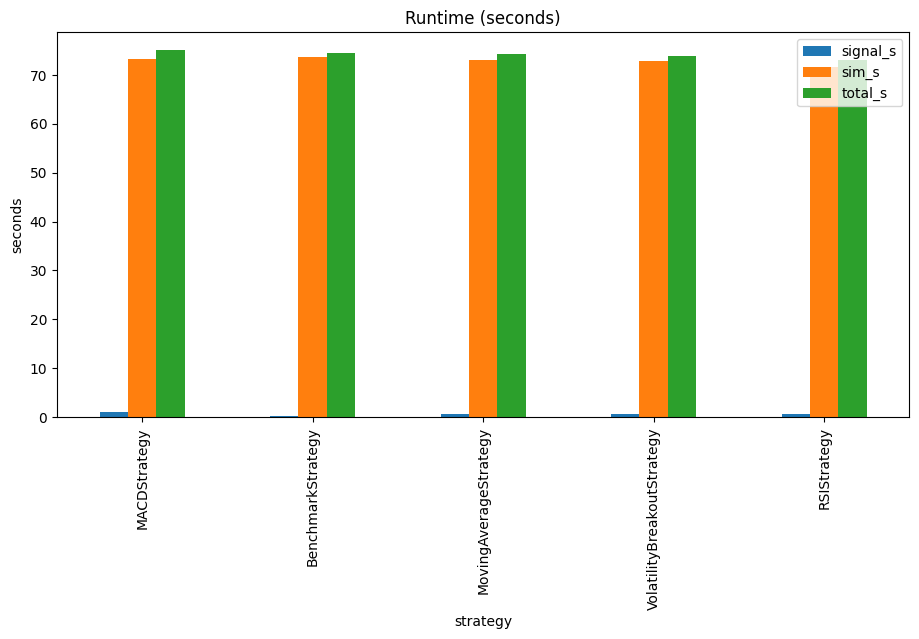

In [10]:
display(
    timing_df[["tickers","rows_total","trades_total","load_s","signal_s","sim_s","total_s"]]
      .sort_values("total_s", ascending=False)
      .style.format({
          "load_s":"{:.2f}","signal_s":"{:.2f}",
          "sim_s":"{:.2f}","total_s":"{:.2f}"
      })
)

# quick bars
ax = timing_df[["signal_s","sim_s","total_s"]].plot(kind="bar", title="Runtime (seconds)")
ax.set_ylabel("seconds"); plt.show()


## Summary

- We produced all required charts **from CSVs**: **signal overlay**, **holdings/cash/total assets**, and **cumulative PnL comparison** across strategies.
- **Performance:** MA leads nominal PnL on this universe; VolBreak is next; MACD/RSI smaller but efficient; Benchmark stable and interpretable.
- **Speed:** End-to-end per strategy is ~73 s on 478 names, with simulation dominating runtime.
- **Caveat:** The aggregate method here does not share cash across names; for a strict capital-constrained backtest, switch to a shared-cash engine and re-evaluate Sharpe/DD.
